# Import Images

In [ ]:
import gdown

base_url = 'https://drive.google.com/uc?id='

r1_img = base_url + '1GnQdfXZkvaBaDum_bfB6chFoY_uIhE9m'
l1_img = base_url + '1KBah3KV9XAzzQYbgmg-aAItCOHhTwtAh'

gdown.download(l1_img)
gdown.download(r1_img)

Downloading...
From: https://drive.google.com/uc?id=1KBah3KV9XAzzQYbgmg-aAItCOHhTwtAh
To: /content/l1.png
100%|██████████| 111k/111k [00:00<00:00, 50.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1GnQdfXZkvaBaDum_bfB6chFoY_uIhE9m
To: /content/r1.png
100%|██████████| 111k/111k [00:00<00:00, 58.0MB/s]


'r1.png'

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
l1 = cv2.imread('l1.png', cv2.IMREAD_GRAYSCALE)
r1 = cv2.imread('r1.png', cv2.IMREAD_GRAYSCALE)


print(l1.shape)
print(r1.shape)

(289, 382)
(289, 382)


# Part 1

## Base Code

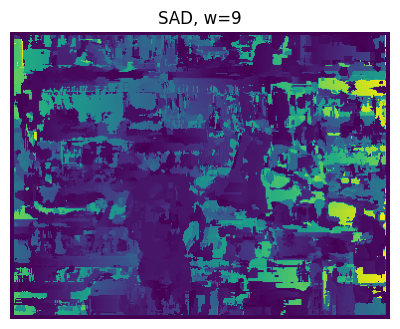

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def compute_disparity(left_image: np.ndarray, right_image: np.ndarray, window_size: int, method: str) -> np.ndarray:
    """
    Compute the disparity map for a pair of stereo images using either SAD or SSD as the cost function.

    Args:
        left_image (np.ndarray): The left image.
        right_image (np.ndarray): The right image.
        window_size (int): The size of the matching window (must be odd).
        method (str): The method for calculating the cost ('SAD' or 'SSD').

    Returns:
        np.ndarray: The disparity map.
    """
    assert method in ['SAD', 'SSD'], "Method must be either 'SAD' or 'SSD'"

    half_window = window_size // 2
    height, width = left_image.shape
    disparity_map = np.zeros_like(left_image, dtype=np.float32)

    for y in range(half_window, height - half_window):
        for x in range(half_window, width - half_window):
            best_offset = 0
            min_cost = float('inf')

            left_window = left_image[y - half_window:y + half_window + 1, x - half_window:x + half_window + 1]

            for offset in range(half_window, width - half_window):
                x_right = offset

                right_window = right_image[y - half_window:y + half_window + 1, x_right - half_window:x_right + half_window + 1]

                if method == 'SAD':
                    cost = np.sum(np.abs(left_window - right_window))
                elif method == 'SSD':
                    cost = np.sum((left_window - right_window) ** 2)

                if cost < min_cost:
                    min_cost = cost
                    best_offset = abs(offset - x)

            disparity_map[y, x] = abs(best_offset)

    # Normalize the disparity map to the range 0-255 for visualization
    disparity_map = cv2.normalize(disparity_map, None, 0, 255, cv2.NORM_MINMAX)

    return disparity_map.astype(np.uint8)

def visualize_disparity_maps(disparity_maps: dict):
    """
    Visualize the disparity maps.

    Args:
        disparity_maps (dict): A dictionary where keys are labels and values are disparity maps.
    """
    plt.figure(figsize=(12, 8))

    for i, (label, disparity_map) in enumerate(disparity_maps.items()):
        plt.subplot(2, 3, i + 1)
        plt.imshow(disparity_map, cmap='viridis')
        plt.title(label)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# Load left and right images (grayscale)
left_image = cv2.imread('/content/l1.png', cv2.IMREAD_GRAYSCALE)
right_image = cv2.imread('/content/r1.png', cv2.IMREAD_GRAYSCALE)

if left_image is None or right_image is None:
    raise FileNotFoundError("Could not load one or both images. Make sure 'left_image.png' and 'right_image.png' exist.")

window_sizes = [9] #[1, 5, 9]
methods = ['SAD'] #['SAD', 'SSD']

disparity_maps = {}

for window_size in window_sizes:
    for method in methods:
        label = f'{method}, w={window_size}'
        disparity_map = compute_disparity(left_image, right_image, window_size, method)
        disparity_maps[label] = disparity_map

visualize_disparity_maps(disparity_maps)



## Optimization 1

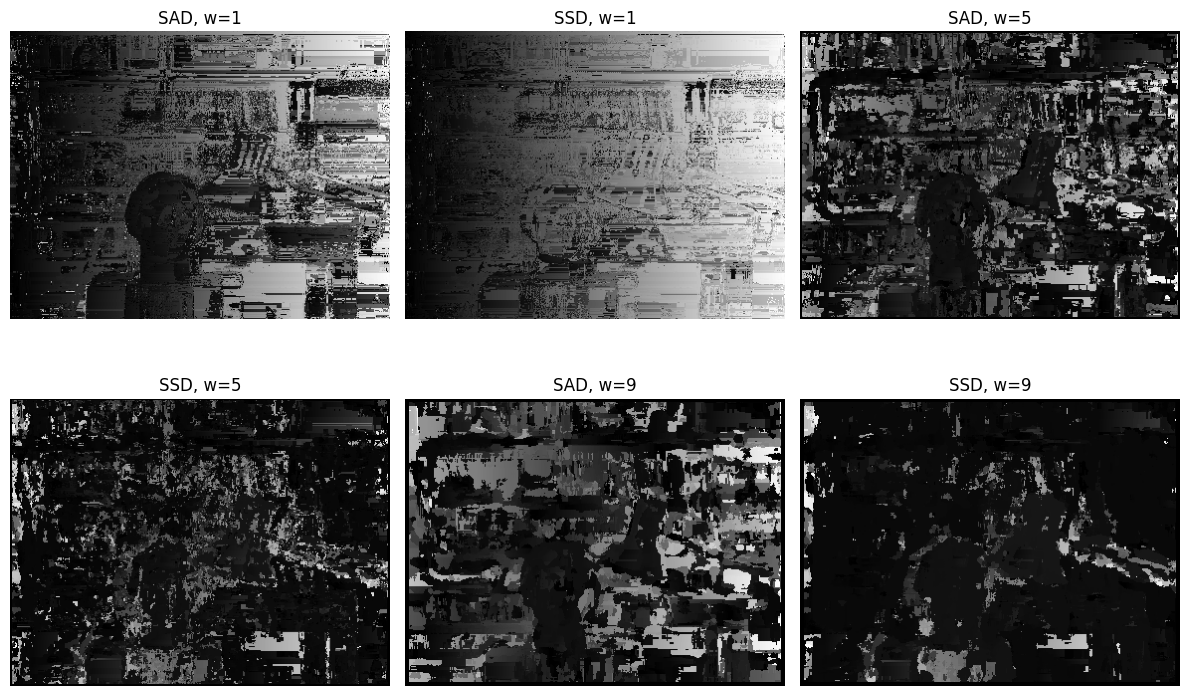

In [ ]:
def compute_disparity(left_image: np.ndarray, right_image: np.ndarray, window_size: int, method: str) -> np.ndarray:
    """
    Compute the disparity map for a pair of stereo images using either SAD or SSD as the cost function.

    Args:
        left_image (np.ndarray): The left image.
        right_image (np.ndarray): The right image.
        window_size (int): The size of the matching window (must be odd).
        method (str): The method for calculating the cost ('SAD' or 'SSD').

    Returns:
        np.ndarray: The disparity map.
    """
    assert method in ['SAD', 'SSD'], "Method must be either 'SAD' or 'SSD'"

    half_window = window_size // 2
    height, width = left_image.shape
    disparity_map = np.zeros_like(left_image, dtype=np.float32)

    for y in range(half_window, height - half_window):
        for x in range(half_window, width - half_window):
            best_offset = 0
            min_cost = float('inf')

            left_window = left_image[y - half_window:y + half_window + 1, x - half_window:x + half_window + 1]

            right_windows = [right_image[y - half_window:y + half_window + 1, x_r - half_window:x_r + half_window + 1] for x_r in range(half_window, width - half_window)]
            right_windows = np.array(right_windows)

            differences = left_window - right_windows

            if method == 'SAD':
                cost = np.sum(np.abs(differences), axis=(1, 2))
            elif method == 'SSD':
                cost = np.sum(differences ** 2, axis=(1, 2))

            best_offset = np.argmin(cost) - x

            disparity_map[y, x] = abs(best_offset)

    # Normalize the disparity map to the range 0-255 for visualization
    disparity_map = (disparity_map / np.max(disparity_map)) * 255

    return disparity_map.astype(np.uint8)



def visualize_disparity_maps(disparity_maps: dict):
    """
    Visualize the disparity maps.

    Args:
        disparity_maps (dict): A dictionary where keys are labels and values are disparity maps.
    """
    plt.figure(figsize=(12, 8))

    for i, (label, disparity_map) in enumerate(disparity_maps.items()):
        plt.subplot(2, 3, i + 1)
        plt.imshow(disparity_map, cmap='grey')
        plt.title(label)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# Load left and right images (grayscale)
left_image = cv2.imread('/content/l1.png', cv2.IMREAD_GRAYSCALE)
right_image = cv2.imread('/content/r1.png', cv2.IMREAD_GRAYSCALE)

if left_image is None or right_image is None:
    raise FileNotFoundError("Could not load one or both images. Make sure 'left_image.png' and 'right_image.png' exist.")

window_sizes = [1, 5, 9]
methods = ['SAD', 'SSD']

disparity_maps = {}

for window_size in window_sizes:
    for method in methods:
        label = f'{method}, w={window_size}'
        disparity_map = compute_disparity(left_image, right_image, window_size, method)
        disparity_maps[label] = disparity_map

visualize_disparity_maps(disparity_maps)

## Optimization 2

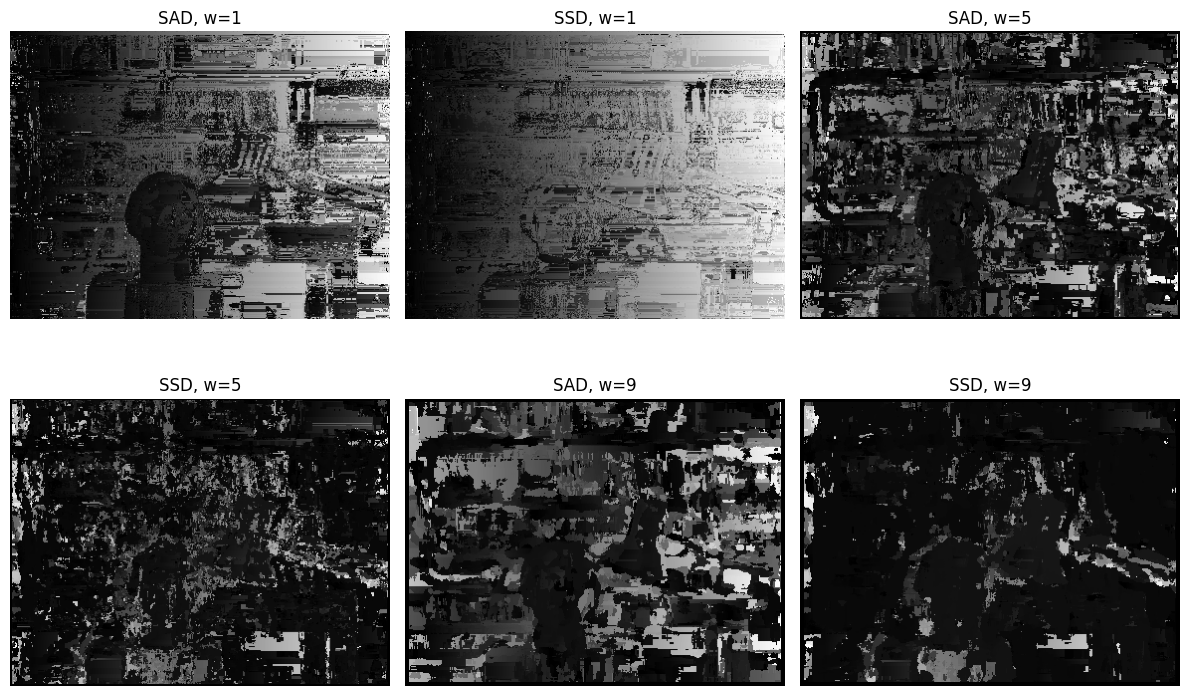

In [ ]:
import numpy as np


def compute_disparity(left_image: np.ndarray, right_image: np.ndarray, window_size: int, method: str) -> np.ndarray:
    """
    Compute the disparity map for a pair of stereo images using either SAD or SSD as the cost function.

    Args:
        left_image (np.ndarray): The left image.
        right_image (np.ndarray): The right image.
        window_size (int): The size of the matching window (must be odd).
        method (str): The method for calculating the cost ('SAD' or 'SSD').

    Returns:
        np.ndarray: The disparity map.
    """
    assert method in ['SAD', 'SSD'], "Method must be either 'SAD' or 'SSD'"

    half_window = window_size // 2
    height, width = left_image.shape
    disparity_map = np.zeros_like(left_image, dtype=np.float32)

    for y in range(half_window, height - half_window):
        for x in range(half_window, width - half_window):
            best_offset = 0
            min_cost = float('inf')

            left_window = left_image[y - half_window:y + half_window + 1, x - half_window:x + half_window + 1]

            right_windows = right_image[y - half_window:y + half_window + 1,:] # Get horizontal strip in the image containing all blocks on the same horizontal line
            right_windows = np.lib.stride_tricks.sliding_window_view(right_windows, window_shape=(window_size, window_size)).squeeze(axis=0) # Extract all WxW windows with stride = 1
            differences = left_window - right_windows # Calculate all differences, left window will be broadcasted by numpy

            if method == 'SAD':
                cost = np.sum(np.abs(differences), axis=(1, 2))
            elif method == 'SSD':
                cost = np.sum(differences ** 2, axis=(1, 2))

            best_offset = x - np.argmin(cost)

            disparity_map[y, x] = abs(best_offset)

    # Normalize the disparity map to the range 0-255 for visualization
    disparity_map = (disparity_map / np.max(disparity_map)) * 255

    return disparity_map.astype(np.uint8)

def visualize_disparity_maps(disparity_maps: dict):
    """
    Visualize the disparity maps.

    Args:
        disparity_maps (dict): A dictionary where keys are labels and values are disparity maps.
    """
    plt.figure(figsize=(12, 8))

    for i, (label, disparity_map) in enumerate(disparity_maps.items()):
        plt.subplot(2, 3, i + 1)
        plt.imshow(disparity_map, cmap='grey')
        plt.title(label)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# Load left and right images (grayscale)
left_image = cv2.imread('/content/l1.png', cv2.IMREAD_GRAYSCALE)
right_image = cv2.imread('/content/r1.png', cv2.IMREAD_GRAYSCALE)

if left_image is None or right_image is None:
    raise FileNotFoundError("Could not load one or both images. Make sure 'left_image.png' and 'right_image.png' exist.")

window_sizes = [1, 5, 9]
methods = ['SAD', 'SSD']

disparity_maps = {}

for window_size in window_sizes:
    for method in methods:
        label = f'{method}, w={window_size}'
        disparity_map = compute_disparity(left_image, right_image, window_size, method)
        disparity_maps[label] = disparity_map

visualize_disparity_maps(disparity_maps)

In [ ]:
print(disparity_maps.keys())
print(disparity_maps['SAD, w=5'])

dict_keys(['SAD, w=1', 'SSD, w=1', 'SAD, w=5', 'SSD, w=5', 'SAD, w=9', 'SSD, w=9'])
[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0  35 ...   1   0   0]
 ...
 [  0   0 128 ...   1   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


## Optimization 3

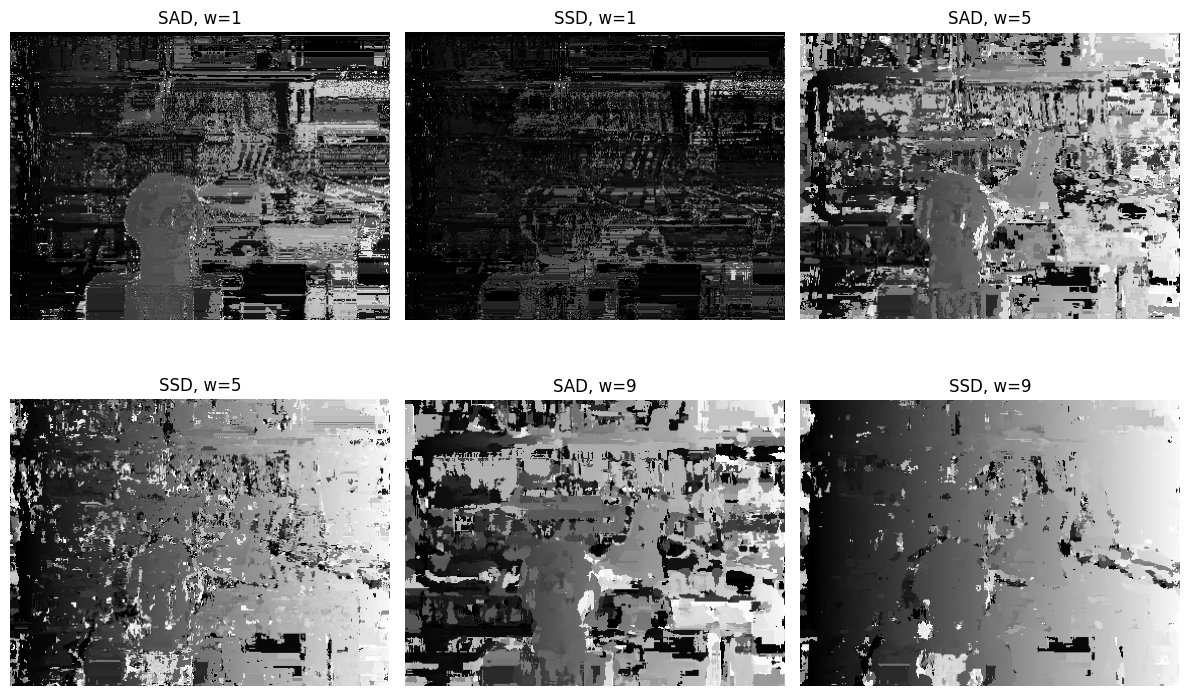

In [ ]:
import numpy as np


def compute_disparity(left_image: np.ndarray, right_image: np.ndarray, window_size: int, method: str) -> np.ndarray:
    """
    Compute the disparity map for a pair of stereo images using either SAD or SSD as the cost function.

    Args:
        left_image (np.ndarray): The left image.
        right_image (np.ndarray): The right image.
        window_size (int): The size of the matching window (must be odd).
        method (str): The method for calculating the cost ('SAD' or 'SSD').

    Returns:
        np.ndarray: The disparity map.
    """
    assert method in ['SAD', 'SSD'], "Method must be either 'SAD' or 'SSD'"

    half_window = window_size // 2
    height, width = left_image.shape
    disparity_map = np.zeros_like(left_image, dtype=np.float32)

    left_windows = np.lib.stride_tricks.sliding_window_view(left_image, window_shape=(window_size, window_size))
    right_windows = np.lib.stride_tricks.sliding_window_view(right_image, window_shape=(window_size, window_size))


    left_windows = np.expand_dims(left_windows, axis=1)
    right_windows = np.expand_dims(right_windows, axis=2)

    differences = left_windows - right_windows

    if method == 'SAD':
        cost = np.sum(np.abs(differences), axis=(3, 4))
    elif method == 'SSD':
        cost = np.sum(differences ** 2, axis=(3, 4))

    disparity_map = np.argmin(cost, axis=1)

    # Normalize the disparity map to the range 0-255 for visualization
    disparity_map = cv2.normalize(disparity_map, None, 0, 255, cv2.NORM_MINMAX)

    return disparity_map.astype(np.uint8)

def visualize_disparity_maps(disparity_maps: dict):
    """
    Visualize the disparity maps.

    Args:
        disparity_maps (dict): A dictionary where keys are labels and values are disparity maps.
    """
    plt.figure(figsize=(12, 8))

    for i, (label, disparity_map) in enumerate(disparity_maps.items()):
        plt.subplot(2, 3, i + 1)
        plt.imshow(disparity_map, cmap='grey')
        plt.title(label)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# Load left and right images (grayscale)
left_image = cv2.imread('/content/l1.png', cv2.IMREAD_GRAYSCALE)
right_image = cv2.imread('/content/r1.png', cv2.IMREAD_GRAYSCALE)

if left_image is None or right_image is None:
    raise FileNotFoundError("Could not load one or both images. Make sure 'left_image.png' and 'right_image.png' exist.")

window_sizes = [1, 5, 9]
methods = ['SAD', 'SSD']

disparity_maps = {}

for window_size in window_sizes:
    for method in methods:
        label = f'{method}, w={window_size}'
        disparity_map = compute_disparity(left_image, right_image, window_size, method)
        disparity_maps[label] = disparity_map

visualize_disparity_maps(disparity_maps)

# DP

In [ ]:
import cv2
import numpy as np

def compute_disparity_dynamic(Il, Ir, sigma=2, c0=1):
    # Convert images to float for arithmetic operations to prevent overflow
    Il = Il.astype(np.int16)
    Ir = Ir.astype(np.int16)

    h, w = Il.shape
    disparity_left = np.zeros((h, w), dtype=np.int16)
    disparity_right = np.zeros((h, w), dtype=np.int16)

    for row in range(h):
        # Get the scanlines for the current row
        Il_row = Il[row]
        Ir_row = Ir[row]
        n = len(Il_row)

        # Initialize cost matrix D
        D = np.zeros((n+1, n+1))
        D[0, :] = np.arange(n+1) * c0
        D[:, 0] = np.arange(n+1) * c0

        # Compute costs
        for i in range(1, n+1):
            for j in range(1, n+1):
                d_ij = ((Il_row[i-1] - Ir_row[j-1]) ** 2) / (sigma ** 2)
                D[i, j] = min(
                    D[i-1, j-1] + d_ij,  # Match pixels
                    D[i-1, j] + c0,      # Skip pixel in Il
                    D[i, j-1] + c0       # Skip pixel in Ir
                )

        # Backtracking
        i, j = n, n
        while i > 0 and j > 0:
            if i > 0 and j > 0 and D[i, j] == D[i-1, j-1] + ((Il_row[i-1] - Ir_row[j-1]) ** 2) / (sigma ** 2):
                # Match pixels
                disparity_left[row, i-1] = abs(i-1 - j-1)
                disparity_right[row, j-1] = abs(j-1 - i-1)
                i, j = i-1, j-1
            elif i > 0 and D[i, j] == D[i-1, j] + c0:
                # Skip pixel in Il
                i -= 1
            else:
                # Skip pixel in Ir
                j -= 1

    return disparity_left, disparity_right

# Load images
Il = cv2.imread('l1.png', cv2.IMREAD_GRAYSCALE)
Ir = cv2.imread('r1.png', cv2.IMREAD_GRAYSCALE)

# Compute disparity maps
Dl, Dr = compute_disparity_dynamic(Il, Ir)

# Save disparity maps
cv2.imwrite('disparity_left.png', Dl.astype(np.uint8))
cv2.imwrite('disparity_right.png', Dr.astype(np.uint8))



KeyboardInterrupt: 

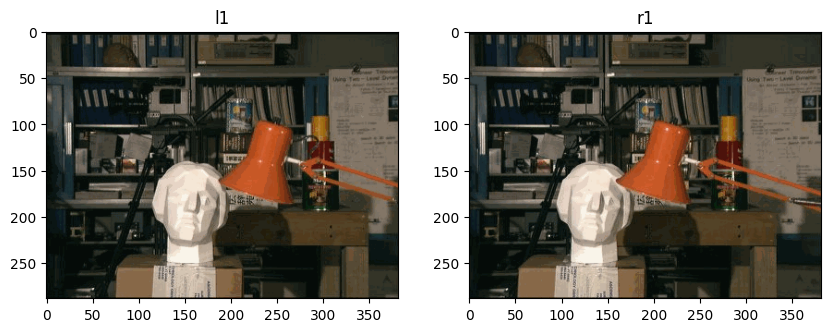

In [ ]:
import matplotlib.pyplot as plt
import cv2

# Load images
l1 = cv2.imread('l1.png')
r1 = cv2.imread('r1.png')

# Convert images to RGB for matplotlib
l1_rgb = cv2.cvtColor(l1, cv2.COLOR_BGR2RGB)
r1_rgb = cv2.cvtColor(r1, cv2.COLOR_BGR2RGB)

# Display the images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(l1_rgb)
plt.title('l1')

plt.subplot(1, 2, 2)
plt.imshow(r1_rgb)
plt.title('r1')

plt.show()

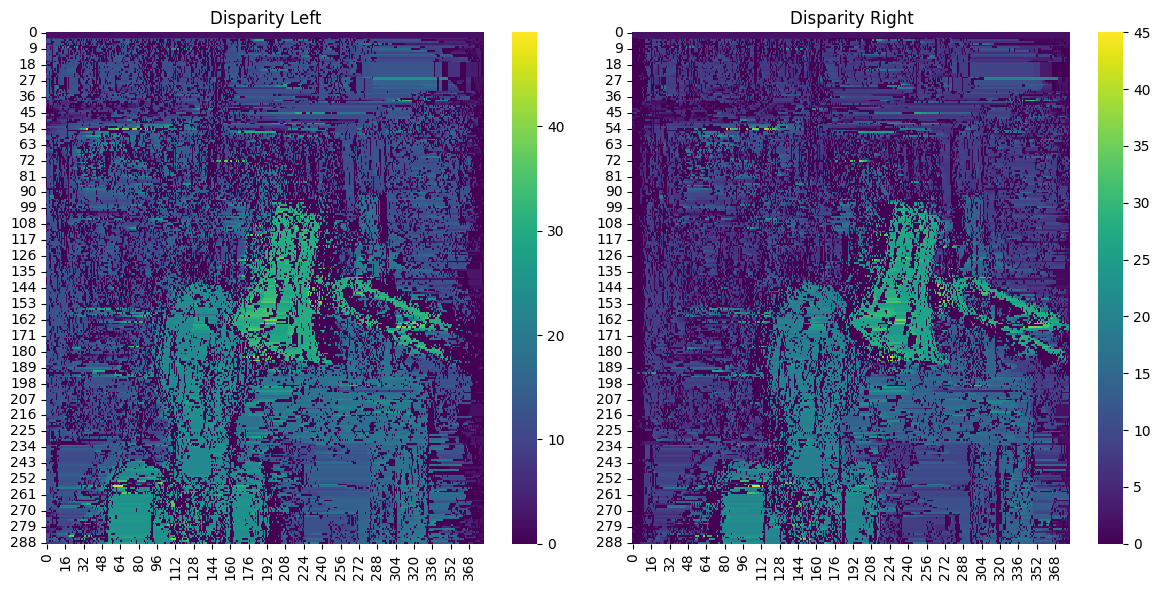

In [ ]:
# prompt: show disparity left and right as a heatmap

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming Dl and Dr are already computed disparity maps
# ... (your existing code to compute Dl and Dr) ...

# Plotting the heatmaps
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.heatmap(Dl, cmap='viridis')
plt.title('Disparity Left')

plt.subplot(1, 2, 2)
sns.heatmap(Dr, cmap='viridis')
plt.title('Disparity Right')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from collections import Counter

# Count the frequency of each disparity value
value_counts = Counter(Dl.flatten())

most_common_values = value_counts.most_common(3)

print("3 most common disparity values:")
for value, count in most_common_values:
    print(f"Value: {value}, Count: {count}")

3 most common disparity values:
Value: 0, Count: 39077
Value: 12, Count: 11651
Value: 13, Count: 6353
